In [1]:
!date

Thu May  4 09:30:11 EDT 2023


In [2]:
pwd

'/mmfs1/data/aglinska/BC-actionpred-seg'

In [3]:
import PIL
from PIL import Image,ImageFilter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from scipy.ndimage.filters import gaussian_filter
import os
import shutil
import random
#import cv2
from skimage.transform import resize
from datetime import datetime
now = datetime.now

/data/aglinska/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [4]:
def load_video(fn):
    import skvideo
    import skvideo.io
    videodata = skvideo.io.vread(fn)
    return videodata

In [5]:
def safe_mkdir(fn):
    import os
    if not os.path.exists(fn):
        os.mkdir(fn)

In [6]:
def resize_and_pad_video(video_data):

    target_size = np.array((360, 640))
    input_size = (video_data.shape[1],video_data.shape[2])
    
    d1 = input_size[0]/target_size[0]
    d2 = input_size[1]/target_size[1]

    choose_size = input_size/max(d1,d2)
    choose_size = choose_size.round().astype(int) ## Hacks?

    video_data_resized = np.array([np.array(Image.fromarray(video_data[frame,:,:,:]).resize(choose_size.astype(int)[-1::-1])) for frame in range(video_data.shape[0])])

    assert any(video_data_resized.shape[1:3]==target_size),'neither dimension matches'

    if not video_data_resized.shape[1]==target_size[0]:

        if np.mod(video_data_resized.shape[1],2)==0:
            p = (target_size[0]-video_data_resized.shape[1])/2
            pp = (p.astype(int),p.astype(int))
        else:
            p = (target_size[0]-video_data_resized.shape[1])/2
            p = np.floor(p)
            pp = (p.astype(int),p.astype(int)+1)

        video_data_resized_padded = np.pad(video_data_resized,((0,0),(pp[0],pp[1]),(0,0),(0,0)))
        padding = np.pad(np.ones(video_data_resized.shape),((0,0),(pp[0],pp[1]),(0,0),(0,0)))[0,:,:,0]

    elif not video_data_resized.shape[2]==target_size[1]:

        if np.mod(video_data_resized.shape[2],2)==0:
            p = (target_size[1]-video_data_resized.shape[2])/2
            pp = (p.astype(int),p.astype(int))
        else:
            p = (target_size[1]-video_data_resized.shape[2])/2
            p = np.floor(p)
            pp = (p.astype(int),p.astype(int)+1)

        video_data_resized_padded = np.pad(video_data_resized,((0,0),(0,0),(pp[0],pp[1]),(0,0)))
        padding = np.pad(np.ones(video_data_resized.shape),((0,0),(0,0),(pp[0],pp[1]),(0,0)))[0,:,:,0]

    else:
        video_data_resized_padded = video_data_resized
        padding = np.ones(video_data_resized.shape)[0,:,:,0]

    assert all(video_data_resized_padded.shape[1:3]==target_size), 'failed resizing'
    
    return video_data_resized_padded,padding

In [7]:
categories = os.listdir('./Data/haa500_v1_1_frames/video/')
categories.sort()
print(categories[0:3])
print(categories[-3::])

['ALS_IceBucket_Challenge', 'CPR', 'abseiling']
['yoga_tree', 'yoga_triangle', 'yoga_updog']


In [8]:
calc_or_load = 'load'

if calc_or_load=='load':
    idx_1p = np.load('good_videos_1p_new_4783.npy')
    
elif calc_or_load=='calc':
    
    idx_1p = np.zeros((20,500))
    box_fn = './Data/haa500_v1_1_frames/video/{c}/{c}_{v:03d}/{c}_{v:03d}_{f:03d}_box.npy'
    for c in tqdm(range(500)):
        for v in range(20):
            boxes = [f for f in os.listdir(f'./Data/haa500_v1_1_frames/video/{categories[c]}/{categories[c]}_{v:03d}/') if f.endswith('_box.npy')]
            n = len(boxes)
            idx_1p[v,c] = all([sum(np.load(box_fn.format(c=categories[c],v=v,f=f))[:,-1]==0)==1 for f in range(n)])
    #np.save('good_videos_1p_new_4783.npy',idx_1p)
else:
    print('undefined')

[0. 1.]
4783.0
(20, 500)


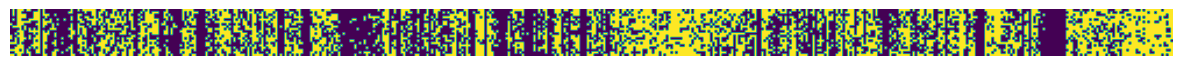

In [9]:
print(np.unique(idx_1p))
print(idx_1p.sum())
print(idx_1p.shape)
plt.figure(figsize=(15,5))
plt.imshow(idx_1p);
plt.axis('off');

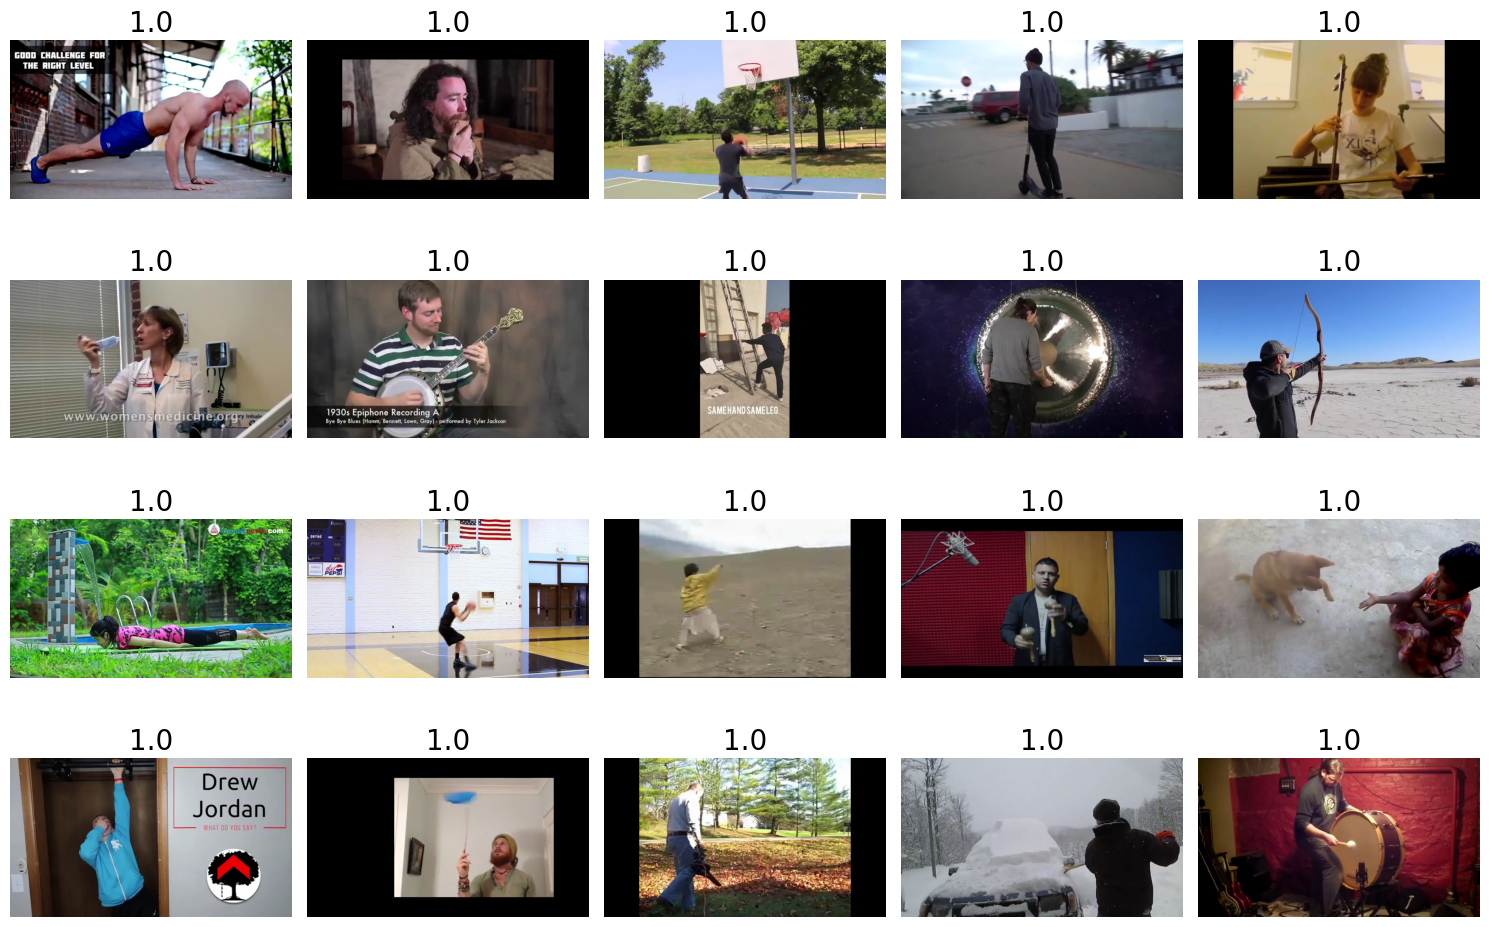

In [10]:
nz = np.nonzero(idx_1p)
plt.figure(figsize=(15,10))
for i in range(20):
    plt.subplot(4,5,i+1)
    r = np.random.randint(low=0,high=len(nz[0]))
    #c = np.random.randint(low=0,high=500)
    #v = np.random.randint(low=0,high=20)
    c = nz[1][r]
    v = nz[0][r]
    f = 0

    im = Image.open('./Data/haa500_v1_1_frames/video/{c}/{c}_{v:03d}/{c}_{v:03d}_{f:03d}.png'.format(c=categories[c],v=v,f=f))
    plt.imshow(np.array(im))
    plt.axis('off')
    plt.title(idx_1p[v,c],fontsize=20)
    
plt.tight_layout()

In [11]:
has_vids = np.zeros((20,500))
for c in tqdm(range(500)):
    for v in range(20):
        fn1 = './Data/haa500_v1_1_yolo_seg4/{c}/{c}_{v:03d}.mp4'.format(c=categories[c],v=v)
        fn2 = './Data/haa500_v1_1_yolo_seg4/{c}/{c}_{v:03d}_item_0_fwd_seg.mp4'.format(c=categories[c],v=v)
        fn3 = './Data/haa500_v1_1_yolo_seg4/{c}/{c}_{v:03d}_item_0_inp_seg.mp4'.format(c=categories[c],v=v)
        has_vids[v,c] = all([os.path.exists(fn) for fn in [fn1,fn2,fn3]])

  0%|          | 0/500 [00:00<?, ?it/s]

  1%|          | 4/500 [00:00<00:14, 35.06it/s]

  2%|▏         | 8/500 [00:00<00:14, 34.81it/s]

  2%|▏         | 12/500 [00:00<00:13, 35.92it/s]

  3%|▎         | 16/500 [00:00<00:13, 36.36it/s]

  4%|▍         | 21/500 [00:00<00:12, 37.98it/s]

  5%|▌         | 26/500 [00:00<00:11, 40.26it/s]

  6%|▌         | 31/500 [00:00<00:11, 41.68it/s]

  7%|▋         | 36/500 [00:00<00:11, 40.95it/s]

  8%|▊         | 41/500 [00:01<00:11, 41.55it/s]

  9%|▉         | 46/500 [00:01<00:11, 40.72it/s]

 10%|█         | 51/500 [00:01<00:11, 39.76it/s]

 11%|█         | 56/500 [00:01<00:10, 40.91it/s]

 12%|█▏        | 61/500 [00:01<00:10, 41.44it/s]

 13%|█▎        | 66/500 [00:01<00:10, 41.67it/s]

 14%|█▍        | 71/500 [00:01<00:10, 39.98it/s]

 15%|█▌        | 76/500 [00:01<00:10, 39.52it/s]

 16%|█▌        | 80/500 [00:02<00:11, 37.69it/s]

 17%|█▋        | 84/500 [00:02<00:11, 37.03it/s]

 18%|█▊        | 88/500 [00:02<00:10, 37.48it/s]

 18%|█▊        | 92/500 [00:02<00:10, 37.50it/s]

 19%|█▉        | 96/500 [00:02<00:10, 37.63it/s]

 20%|██        | 100/500 [00:02<00:10, 36.68it/s]

 21%|██        | 104/500 [00:02<00:10, 37.29it/s]

 22%|██▏       | 109/500 [00:02<00:10, 38.55it/s]

 23%|██▎       | 113/500 [00:02<00:10, 38.57it/s]

 23%|██▎       | 117/500 [00:03<00:10, 37.24it/s]

 24%|██▍       | 121/500 [00:03<00:10, 37.13it/s]

 25%|██▌       | 125/500 [00:03<00:10, 36.11it/s]

 26%|██▌       | 131/500 [00:03<00:09, 40.46it/s]

 27%|██▋       | 136/500 [00:03<00:09, 38.32it/s]

 28%|██▊       | 140/500 [00:03<00:09, 37.18it/s]

 29%|██▉       | 144/500 [00:03<00:09, 37.32it/s]

 30%|██▉       | 149/500 [00:03<00:08, 39.73it/s]

 31%|███       | 154/500 [00:03<00:08, 40.63it/s]

 32%|███▏      | 159/500 [00:04<00:08, 40.17it/s]

 33%|███▎      | 164/500 [00:04<00:08, 37.92it/s]

 34%|███▎      | 168/500 [00:04<00:08, 38.33it/s]

 34%|███▍      | 172/500 [00:04<00:08, 38.10it/s]

 35%|███▌      | 176/500 [00:04<00:08, 36.71it/s]

 36%|███▌      | 180/500 [00:04<00:08, 36.10it/s]

 37%|███▋      | 184/500 [00:04<00:08, 35.36it/s]

 38%|███▊      | 188/500 [00:04<00:09, 34.49it/s]

 38%|███▊      | 192/500 [00:05<00:09, 34.10it/s]

 39%|███▉      | 196/500 [00:05<00:08, 34.31it/s]

 40%|████      | 200/500 [00:05<00:08, 35.48it/s]

 41%|████      | 204/500 [00:05<00:08, 35.56it/s]

 42%|████▏     | 208/500 [00:05<00:08, 34.45it/s]

 42%|████▏     | 212/500 [00:05<00:08, 35.38it/s]

 43%|████▎     | 216/500 [00:05<00:08, 35.18it/s]

 44%|████▍     | 220/500 [00:05<00:08, 34.35it/s]

 45%|████▌     | 226/500 [00:05<00:07, 39.14it/s]

 46%|████▌     | 230/500 [00:06<00:06, 38.70it/s]

 47%|████▋     | 234/500 [00:06<00:06, 38.68it/s]

 48%|████▊     | 238/500 [00:06<00:06, 38.02it/s]

 48%|████▊     | 242/500 [00:06<00:06, 38.50it/s]

 49%|████▉     | 246/500 [00:06<00:06, 38.88it/s]

 50%|█████     | 251/500 [00:06<00:06, 40.43it/s]

 51%|█████     | 256/500 [00:06<00:05, 41.16it/s]

 52%|█████▏    | 261/500 [00:06<00:05, 40.67it/s]

 53%|█████▎    | 266/500 [00:06<00:05, 39.39it/s]

 54%|█████▍    | 270/500 [00:07<00:05, 38.78it/s]

 55%|█████▍    | 274/500 [00:07<00:06, 37.41it/s]

 56%|█████▌    | 278/500 [00:07<00:06, 36.65it/s]

 56%|█████▋    | 282/500 [00:07<00:06, 35.74it/s]

 57%|█████▋    | 286/500 [00:07<00:06, 35.05it/s]

 58%|█████▊    | 290/500 [00:07<00:06, 34.48it/s]

 59%|█████▉    | 294/500 [00:07<00:06, 32.76it/s]

 60%|█████▉    | 298/500 [00:07<00:06, 33.20it/s]

 60%|██████    | 302/500 [00:08<00:06, 32.60it/s]

 61%|██████    | 306/500 [00:08<00:05, 32.39it/s]

 62%|██████▏   | 310/500 [00:08<00:05, 32.53it/s]

 63%|██████▎   | 314/500 [00:08<00:05, 32.54it/s]

 64%|██████▎   | 318/500 [00:08<00:05, 32.70it/s]

 65%|██████▍   | 323/500 [00:08<00:05, 34.70it/s]

 65%|██████▌   | 327/500 [00:08<00:05, 34.56it/s]

 66%|██████▌   | 331/500 [00:08<00:05, 33.68it/s]

 67%|██████▋   | 335/500 [00:09<00:04, 33.30it/s]

 68%|██████▊   | 339/500 [00:09<00:04, 33.52it/s]

 69%|██████▊   | 343/500 [00:09<00:04, 34.34it/s]

 69%|██████▉   | 347/500 [00:09<00:04, 34.40it/s]

 70%|███████   | 351/500 [00:09<00:04, 35.01it/s]

 71%|███████   | 355/500 [00:09<00:04, 36.12it/s]

 72%|███████▏  | 359/500 [00:09<00:03, 36.69it/s]

 73%|███████▎  | 363/500 [00:09<00:03, 35.58it/s]

 73%|███████▎  | 367/500 [00:09<00:03, 35.10it/s]

 74%|███████▍  | 371/500 [00:10<00:03, 34.27it/s]

 75%|███████▌  | 375/500 [00:10<00:03, 34.61it/s]

 76%|███████▌  | 381/500 [00:10<00:03, 39.23it/s]

 77%|███████▋  | 385/500 [00:10<00:03, 37.42it/s]

 78%|███████▊  | 389/500 [00:10<00:02, 37.25it/s]

 79%|███████▉  | 394/500 [00:10<00:02, 38.58it/s]

 80%|███████▉  | 399/500 [00:10<00:02, 39.44it/s]

 81%|████████  | 403/500 [00:10<00:02, 38.47it/s]

 81%|████████▏ | 407/500 [00:10<00:02, 37.28it/s]

 82%|████████▏ | 411/500 [00:11<00:02, 36.71it/s]

 83%|████████▎ | 415/500 [00:11<00:02, 36.81it/s]

 84%|████████▍ | 422/500 [00:11<00:01, 44.37it/s]

 85%|████████▌ | 427/500 [00:11<00:01, 41.64it/s]

 86%|████████▋ | 432/500 [00:11<00:01, 40.22it/s]

 87%|████████▋ | 437/500 [00:11<00:01, 38.04it/s]

 88%|████████▊ | 441/500 [00:11<00:01, 37.29it/s]

 89%|████████▉ | 447/500 [00:11<00:01, 40.58it/s]

 90%|█████████ | 452/500 [00:12<00:01, 40.15it/s]

 91%|█████████▏| 457/500 [00:12<00:01, 38.69it/s]

 92%|█████████▏| 461/500 [00:12<00:01, 35.20it/s]

 93%|█████████▎| 465/500 [00:12<00:01, 33.70it/s]

 94%|█████████▍| 469/500 [00:12<00:00, 32.64it/s]

 95%|█████████▍| 473/500 [00:12<00:00, 32.63it/s]

 95%|█████████▌| 477/500 [00:12<00:00, 33.44it/s]

 96%|█████████▌| 481/500 [00:13<00:00, 32.57it/s]

 97%|█████████▋| 485/500 [00:13<00:00, 32.93it/s]

 98%|█████████▊| 489/500 [00:13<00:00, 33.35it/s]

 99%|█████████▊| 493/500 [00:13<00:00, 34.15it/s]

 99%|█████████▉| 497/500 [00:13<00:00, 34.24it/s]

100%|██████████| 500/500 [00:13<00:00, 36.83it/s]

In [12]:
print(has_vids.sum())
print((has_vids==0).sum())

9371.0
629


In [13]:
good_videos_xl = has_vids.astype(bool)*idx_1p.astype(bool)
good_videos_xl.shape

(20, 500)

In [14]:
print(sum(good_videos_xl.sum(axis=0)>=17))
print(sum(good_videos_xl.sum(axis=0)>=15))
print(sum(good_videos_xl.sum(axis=0)>=10))

60
121
280


In [15]:
minVids = 10

In [16]:
good_videos_xl[:,good_videos_xl.sum(axis=0)<minVids]=0

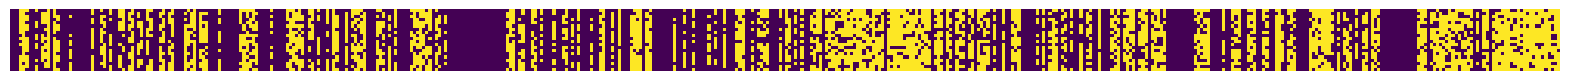

In [17]:
plt.figure(figsize=(20,5))
plt.imshow(good_videos_xl)
plt.axis('off');

In [18]:
good_cats = np.nonzero(good_videos_xl.sum(axis=0)>=minVids)[0]
good_cats_list = list(np.array(categories)[good_cats])
good_vids = [np.nonzero(good_videos_xl[:,good_cat])[0][0:minVids] for good_cat in good_cats]

In [19]:
ng = len(good_cats)
print(ng)

280


In [20]:
# parameters
outdir = './Data/pytorch-data/xl_121_15_action_data_orig'
fn_temp = './Data/haa500_v1_1_yolo_seg4/{c}/{c}_{v:03d}.mp4'
# './Data/haa500_v1_1_yolo_seg4/{c}/{c}_{v:03d}.mp4'
# './Data/haa500_v1_1_yolo_seg4/{c}/{c}_{v:03d}_item_0_fwd_seg.mp4'
# './Data/haa500_v1_1_yolo_seg4/{c}/{c}_{v:03d}_item_0_inp_seg.mp4'
#fn_temp = './Data/haa500_v1_1_resized/video/{c}/{c}_{v:03d}.mp4'

In [21]:
# Parameters
outdir = "./Data/pytorch-data/xl_280_10_action_data_bg"
fn_temp = "./Data/haa500_v1_1_yolo_seg4/{c}/{c}_{v:03d}_item_0_inp_seg.mp4"


In [22]:
## Make/Define Directories
safe_mkdir(outdir)

safe_mkdir(os.path.join(outdir,'train'))
safe_mkdir(os.path.join(outdir,'val'))
safe_mkdir(os.path.join(outdir,'test'))

[safe_mkdir(os.path.join(outdir,'train',category)) for category in good_cats_list];
[safe_mkdir(os.path.join(outdir,'val',category)) for category in good_cats_list];
[safe_mkdir(os.path.join(outdir,'test',category)) for category in good_cats_list];

In [23]:
# Run Main Loop
for c in tqdm(range(ng)):
    for v in range(minVids):              
        fn = fn_temp.format(c=categories[good_cats[c]],v=good_vids[c][v])
        video_data = load_video(fn)
        assert all((video_data.shape[1]==360,video_data.shape[2]==640)),f'bad size dumbass: {video_data.shape}'
        
        nframes = video_data.shape[0]
        video_data = resize(np.pad(video_data,((0,0),(140,140),(0,0),(0,0))),(nframes,224,224,3)) # resize to 244*244 (0-1 range)
        video_data = (video_data*255).astype(np.uint8) # make into 0-255 uint
              
        if v==0:
            outdir_subfolder = os.path.join(outdir,'val',categories[good_cats[c]])
        elif v==1:
            outdir_subfolder = os.path.join(outdir,'test',categories[good_cats[c]])
        else:
            outdir_subfolder = os.path.join(outdir,'train',categories[good_cats[c]])

        [Image.fromarray(video_data[f,:,:,:]).save(os.path.join(outdir_subfolder,f'{good_vids[c][v]:03d}_{f:03d}.jpg')) for f in range(nframes)];

  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 1/280 [22:00<102:20:03, 1320.44s/it]

  1%|          | 2/280 [23:26<45:54:01, 594.40s/it]  

  1%|          | 3/280 [30:16<39:14:17, 509.96s/it]

  1%|▏         | 4/280 [31:06<25:10:28, 328.36s/it]

  2%|▏         | 5/280 [42:22<34:40:06, 453.84s/it]

  2%|▏         | 6/280 [1:07:06<61:11:52, 804.06s/it]

  2%|▎         | 7/280 [1:08:16<42:46:59, 564.17s/it]

  3%|▎         | 8/280 [1:08:40<29:38:19, 392.28s/it]

  3%|▎         | 9/280 [1:08:52<20:34:58, 273.43s/it]

  4%|▎         | 10/280 [1:09:09<14:34:07, 194.25s/it]

  4%|▍         | 11/280 [1:10:53<12:26:00, 166.39s/it]

  4%|▍         | 12/280 [1:11:14<9:06:38, 122.38s/it] 

  5%|▍         | 13/280 [1:11:30<6:41:02, 90.12s/it] 

  5%|▌         | 14/280 [1:24:29<22:02:18, 298.27s/it]

  5%|▌         | 15/280 [1:33:08<26:50:59, 364.75s/it]

  6%|▌         | 16/280 [2:12:37<70:58:59, 967.95s/it]

  6%|▌         | 17/280 [2:31:02<73:43:09, 1009.08s/it]

  6%|▋         | 18/280 [2:48:45<74:38:04, 1025.52s/it]

  7%|▋         | 19/280 [3:01:44<68:57:47, 951.22s/it] 

  7%|▋         | 20/280 [3:24:53<78:12:30, 1082.89s/it]

  8%|▊         | 21/280 [3:27:26<57:48:40, 803.56s/it] 

  8%|▊         | 22/280 [3:36:24<51:53:12, 724.00s/it]

  8%|▊         | 23/280 [3:36:47<36:39:35, 513.52s/it]

  9%|▊         | 24/280 [3:37:07<25:59:22, 365.48s/it]

  9%|▉         | 25/280 [3:37:30<18:36:12, 262.64s/it]

  9%|▉         | 26/280 [3:38:05<13:43:31, 194.53s/it]

 10%|▉         | 27/280 [3:38:22<9:54:41, 141.04s/it] 

 10%|█         | 28/280 [3:38:48<7:27:51, 106.63s/it]

 10%|█         | 29/280 [3:39:04<5:32:48, 79.56s/it] 

 11%|█         | 30/280 [3:39:53<4:53:30, 70.44s/it]

 11%|█         | 31/280 [3:40:23<4:01:41, 58.24s/it]

 11%|█▏        | 32/280 [3:40:42<3:11:38, 46.36s/it]

 12%|█▏        | 33/280 [3:41:19<2:59:39, 43.64s/it]

 12%|█▏        | 34/280 [3:41:44<2:36:24, 38.15s/it]

 12%|█▎        | 35/280 [3:42:27<2:40:55, 39.41s/it]

 13%|█▎        | 36/280 [3:42:48<2:18:24, 34.04s/it]

 13%|█▎        | 37/280 [3:43:08<2:00:40, 29.80s/it]

 14%|█▎        | 38/280 [3:43:32<1:52:34, 27.91s/it]

 14%|█▍        | 39/280 [3:44:08<2:02:46, 30.57s/it]

 14%|█▍        | 40/280 [3:44:31<1:52:37, 28.16s/it]

 15%|█▍        | 41/280 [3:44:54<1:45:29, 26.49s/it]

 15%|█▌        | 42/280 [3:45:29<1:55:52, 29.21s/it]

 15%|█▌        | 43/280 [3:46:00<1:57:20, 29.71s/it]

 16%|█▌        | 44/280 [3:46:30<1:57:36, 29.90s/it]

 16%|█▌        | 45/280 [3:55:39<12:06:51, 185.58s/it]

 16%|█▋        | 46/280 [4:19:27<36:16:40, 558.12s/it]

 17%|█▋        | 47/280 [4:34:34<42:54:31, 662.97s/it]

 17%|█▋        | 48/280 [5:09:52<70:51:16, 1099.47s/it]

 18%|█▊        | 49/280 [5:28:45<71:11:26, 1109.46s/it]

 18%|█▊        | 50/280 [5:51:19<75:33:40, 1182.70s/it]

 18%|█▊        | 51/280 [6:01:45<64:37:11, 1015.86s/it]

 19%|█▊        | 52/280 [6:06:18<50:12:47, 792.84s/it] 

 19%|█▉        | 53/280 [6:25:23<56:39:40, 898.59s/it]

 19%|█▉        | 54/280 [6:30:44<45:32:32, 725.45s/it]

 20%|█▉        | 55/280 [6:31:20<32:24:40, 518.58s/it]

 20%|██        | 56/280 [7:25:33<83:18:40, 1338.93s/it]

 20%|██        | 57/280 [7:25:56<58:28:42, 944.05s/it] 

 21%|██        | 58/280 [7:35:14<51:04:12, 828.16s/it]

 21%|██        | 59/280 [7:35:39<36:02:48, 587.19s/it]

 21%|██▏       | 60/280 [7:36:17<25:49:08, 422.49s/it]

 22%|██▏       | 61/280 [7:36:28<18:11:04, 298.93s/it]

 22%|██▏       | 62/280 [7:36:44<12:58:01, 214.14s/it]

 22%|██▎       | 63/280 [7:37:02<9:22:09, 155.44s/it] 

 23%|██▎       | 64/280 [7:37:29<7:00:22, 116.77s/it]

 23%|██▎       | 65/280 [7:38:16<5:43:19, 95.81s/it] 

 24%|██▎       | 66/280 [7:38:31<4:15:14, 71.56s/it]

 24%|██▍       | 67/280 [7:39:03<3:32:20, 59.81s/it]

 24%|██▍       | 68/280 [7:39:30<2:55:55, 49.79s/it]

 25%|██▍       | 69/280 [7:48:03<11:04:25, 188.93s/it]

 25%|██▌       | 70/280 [7:56:56<17:01:58, 291.99s/it]

 25%|██▌       | 71/280 [8:33:48<50:23:59, 868.13s/it]

 26%|██▌       | 72/280 [8:34:20<35:39:30, 617.17s/it]

 26%|██▌       | 73/280 [8:34:44<25:15:32, 439.29s/it]

 26%|██▋       | 74/280 [8:50:32<33:52:38, 592.03s/it]

 27%|██▋       | 75/280 [8:51:01<24:05:08, 422.97s/it]

 27%|██▋       | 76/280 [8:51:29<17:15:16, 304.49s/it]

 28%|██▊       | 77/280 [8:51:49<12:21:25, 219.14s/it]

 28%|██▊       | 78/280 [8:52:05<8:52:31, 158.17s/it] 

 28%|██▊       | 79/280 [8:52:18<6:24:38, 114.82s/it]

 29%|██▊       | 80/280 [8:52:46<4:55:28, 88.64s/it] 

 29%|██▉       | 81/280 [8:53:11<3:50:46, 69.58s/it]

 29%|██▉       | 82/280 [8:53:47<3:16:26, 59.53s/it]

 30%|██▉       | 83/280 [8:54:28<2:57:08, 53.95s/it]

 30%|███       | 84/280 [8:54:37<2:11:51, 40.37s/it]

 30%|███       | 85/280 [8:54:56<1:50:24, 33.97s/it]

 31%|███       | 86/280 [8:56:15<2:33:28, 47.47s/it]

 31%|███       | 87/280 [8:56:30<2:01:38, 37.82s/it]

 31%|███▏      | 88/280 [8:56:46<1:40:04, 31.27s/it]

 32%|███▏      | 89/280 [8:57:17<1:38:56, 31.08s/it]

 32%|███▏      | 90/280 [8:57:36<1:27:33, 27.65s/it]

 32%|███▎      | 91/280 [8:58:01<1:24:25, 26.80s/it]

 33%|███▎      | 92/280 [8:58:27<1:22:46, 26.42s/it]

 33%|███▎      | 93/280 [8:58:47<1:16:38, 24.59s/it]

 34%|███▎      | 94/280 [8:59:10<1:15:02, 24.21s/it]

 34%|███▍      | 95/280 [8:59:31<1:11:20, 23.14s/it]

 34%|███▍      | 96/280 [8:59:59<1:15:17, 24.55s/it]

 35%|███▍      | 97/280 [9:00:30<1:21:10, 26.61s/it]

 35%|███▌      | 98/280 [9:00:53<1:17:21, 25.50s/it]

 35%|███▌      | 99/280 [9:01:11<1:10:13, 23.28s/it]

 36%|███▌      | 100/280 [9:01:56<1:29:27, 29.82s/it]

 36%|███▌      | 101/280 [9:02:11<1:15:28, 25.30s/it]

 36%|███▋      | 102/280 [9:18:20<15:14:27, 308.24s/it]

 37%|███▋      | 103/280 [9:18:35<10:49:53, 220.30s/it]

 37%|███▋      | 104/280 [9:19:07<8:00:46, 163.90s/it] 

 38%|███▊      | 105/280 [9:19:29<5:54:04, 121.40s/it]

 38%|███▊      | 106/280 [9:19:56<4:29:41, 93.00s/it] 

 38%|███▊      | 107/280 [9:20:09<3:19:17, 69.12s/it]

 39%|███▊      | 108/280 [9:20:20<2:27:31, 51.46s/it]

 39%|███▉      | 109/280 [9:20:52<2:10:05, 45.65s/it]

 39%|███▉      | 110/280 [9:21:29<2:02:23, 43.20s/it]

 40%|███▉      | 111/280 [9:21:58<1:49:49, 38.99s/it]

 40%|████      | 112/280 [9:28:00<6:20:32, 135.91s/it]

 40%|████      | 113/280 [9:28:43<5:00:51, 108.09s/it]

 41%|████      | 114/280 [9:29:24<4:02:54, 87.80s/it] 

 41%|████      | 115/280 [9:43:12<14:12:32, 310.01s/it]

 41%|████▏     | 116/280 [9:46:11<12:19:36, 270.59s/it]

 42%|████▏     | 117/280 [9:46:37<8:55:46, 197.22s/it] 

 42%|████▏     | 118/280 [9:47:14<6:42:16, 148.99s/it]

 42%|████▎     | 119/280 [9:47:31<4:53:51, 109.51s/it]

 43%|████▎     | 120/280 [9:47:59<3:46:36, 84.98s/it] 

 43%|████▎     | 121/280 [9:48:26<2:59:04, 67.57s/it]

 44%|████▎     | 122/280 [9:48:55<2:27:46, 56.12s/it]

 44%|████▍     | 123/280 [9:49:18<2:00:39, 46.11s/it]

 44%|████▍     | 124/280 [9:49:41<1:41:58, 39.22s/it]

 45%|████▍     | 125/280 [9:49:59<1:25:16, 33.01s/it]

 45%|████▌     | 126/280 [9:50:36<1:27:31, 34.10s/it]

 45%|████▌     | 127/280 [9:51:14<1:29:57, 35.27s/it]

 46%|████▌     | 128/280 [9:51:39<1:21:36, 32.21s/it]

 46%|████▌     | 129/280 [9:51:54<1:07:55, 26.99s/it]

 46%|████▋     | 130/280 [9:52:10<59:03, 23.62s/it]  

 47%|████▋     | 131/280 [9:52:35<1:00:11, 24.24s/it]

 47%|████▋     | 132/280 [9:53:10<1:07:26, 27.34s/it]

 48%|████▊     | 133/280 [9:53:38<1:07:13, 27.44s/it]

 48%|████▊     | 134/280 [10:13:09<15:01:48, 370.60s/it]

 48%|████▊     | 135/280 [10:21:36<16:34:45, 411.63s/it]

 49%|████▊     | 136/280 [10:28:13<16:17:29, 407.29s/it]

 49%|████▉     | 137/280 [10:28:46<11:42:45, 294.86s/it]

 49%|████▉     | 138/280 [10:29:36<8:44:15, 221.51s/it] 

 50%|████▉     | 139/280 [10:30:50<6:56:12, 177.11s/it]

 50%|█████     | 140/280 [10:31:12<5:04:48, 130.64s/it]

 50%|█████     | 141/280 [10:31:35<3:47:51, 98.36s/it] 

 51%|█████     | 142/280 [10:31:57<2:53:45, 75.55s/it]

 51%|█████     | 143/280 [10:32:28<2:22:00, 62.19s/it]

 51%|█████▏    | 144/280 [10:32:49<1:52:45, 49.75s/it]

 52%|█████▏    | 145/280 [10:33:14<1:34:45, 42.11s/it]

 52%|█████▏    | 146/280 [10:33:31<1:17:41, 34.78s/it]

 52%|█████▎    | 147/280 [10:33:53<1:08:24, 30.86s/it]

 53%|█████▎    | 148/280 [10:34:21<1:06:13, 30.10s/it]

 53%|█████▎    | 149/280 [10:35:01<1:12:09, 33.05s/it]

 54%|█████▎    | 150/280 [10:35:23<1:04:11, 29.63s/it]

 54%|█████▍    | 151/280 [10:35:54<1:04:48, 30.14s/it]

 54%|█████▍    | 152/280 [10:36:47<1:19:01, 37.04s/it]

 55%|█████▍    | 153/280 [10:37:11<1:09:58, 33.06s/it]

 55%|█████▌    | 154/280 [10:37:46<1:10:44, 33.68s/it]

 55%|█████▌    | 155/280 [10:38:11<1:04:28, 30.95s/it]

 56%|█████▌    | 156/280 [10:38:32<57:56, 28.04s/it]  

 56%|█████▌    | 157/280 [10:38:58<56:07, 27.38s/it]

 56%|█████▋    | 158/280 [10:39:24<55:09, 27.13s/it]

 57%|█████▋    | 159/280 [10:40:00<1:00:02, 29.77s/it]

 57%|█████▋    | 160/280 [10:40:47<1:09:54, 34.96s/it]

 57%|█████▊    | 161/280 [10:41:29<1:13:05, 36.85s/it]

 58%|█████▊    | 162/280 [10:42:03<1:10:59, 36.10s/it]

 58%|█████▊    | 163/280 [10:42:26<1:02:37, 32.12s/it]

 59%|█████▊    | 164/280 [10:42:46<55:21, 28.63s/it]  

 59%|█████▉    | 165/280 [10:43:12<52:54, 27.60s/it]

 59%|█████▉    | 166/280 [10:43:45<55:56, 29.44s/it]

 60%|█████▉    | 167/280 [10:44:11<53:29, 28.41s/it]

 60%|██████    | 168/280 [10:44:36<50:43, 27.17s/it]

 60%|██████    | 169/280 [10:45:03<50:18, 27.20s/it]

 61%|██████    | 170/280 [10:45:34<51:51, 28.28s/it]

 61%|██████    | 171/280 [10:46:10<55:57, 30.80s/it]

 61%|██████▏   | 172/280 [10:46:41<55:20, 30.75s/it]

 62%|██████▏   | 173/280 [10:47:16<56:58, 31.95s/it]

 62%|██████▏   | 174/280 [10:47:44<54:32, 30.87s/it]

 62%|██████▎   | 175/280 [10:48:31<1:02:35, 35.77s/it]

 63%|██████▎   | 176/280 [10:49:14<1:05:31, 37.80s/it]

 63%|██████▎   | 177/280 [10:49:39<58:16, 33.95s/it]  

 64%|██████▎   | 178/280 [10:50:08<55:11, 32.47s/it]

 64%|██████▍   | 179/280 [10:50:36<52:37, 31.26s/it]

 64%|██████▍   | 180/280 [10:51:03<49:47, 29.87s/it]

 65%|██████▍   | 181/280 [10:51:26<46:10, 27.99s/it]

 65%|██████▌   | 182/280 [10:52:17<56:47, 34.77s/it]

 65%|██████▌   | 183/280 [10:52:40<50:16, 31.10s/it]

 66%|██████▌   | 184/280 [10:52:58<43:42, 27.32s/it]

 66%|██████▌   | 185/280 [10:53:30<45:35, 28.79s/it]

 66%|██████▋   | 186/280 [10:53:42<36:55, 23.57s/it]

 67%|██████▋   | 187/280 [10:54:00<33:59, 21.93s/it]

 67%|██████▋   | 188/280 [10:54:32<38:30, 25.12s/it]

 68%|██████▊   | 189/280 [10:54:55<37:10, 24.51s/it]

 68%|██████▊   | 190/280 [10:55:14<34:03, 22.70s/it]

 68%|██████▊   | 191/280 [10:55:40<35:21, 23.84s/it]

 69%|██████▊   | 192/280 [11:00:14<2:24:58, 98.85s/it]

 69%|██████▉   | 193/280 [11:25:18<12:34:17, 520.20s/it]

 69%|██████▉   | 194/280 [11:51:08<19:48:34, 829.24s/it]

 70%|██████▉   | 195/280 [11:54:13<15:01:07, 636.09s/it]

 70%|███████   | 196/280 [12:26:58<24:08:32, 1034.68s/it]

 70%|███████   | 197/280 [13:06:15<33:00:04, 1431.37s/it]

 71%|███████   | 198/280 [13:12:07<25:13:39, 1107.56s/it]

 71%|███████   | 199/280 [13:12:33<17:37:05, 783.03s/it] 

 71%|███████▏  | 200/280 [13:12:52<12:18:34, 553.93s/it]

 72%|███████▏  | 201/280 [13:13:05<8:35:34, 391.57s/it] 

 72%|███████▏  | 202/280 [13:13:29<6:05:50, 281.42s/it]

 72%|███████▎  | 203/280 [13:13:50<4:20:52, 203.28s/it]

 73%|███████▎  | 204/280 [13:14:15<3:09:45, 149.81s/it]

 73%|███████▎  | 205/280 [13:14:40<2:20:09, 112.13s/it]

 74%|███████▎  | 206/280 [13:15:05<1:46:17, 86.18s/it] 

 74%|███████▍  | 207/280 [13:15:19<1:18:34, 64.58s/it]

 74%|███████▍  | 208/280 [13:15:34<59:32, 49.62s/it]  

 75%|███████▍  | 209/280 [13:15:59<50:07, 42.37s/it]

 75%|███████▌  | 210/280 [13:16:20<41:38, 35.69s/it]

 75%|███████▌  | 211/280 [13:16:43<36:49, 32.03s/it]

 76%|███████▌  | 212/280 [13:41:28<8:50:10, 467.81s/it]

 76%|███████▌  | 213/280 [14:16:22<17:47:05, 955.61s/it]

 76%|███████▋  | 214/280 [14:39:59<20:03:37, 1094.20s/it]

 77%|███████▋  | 215/280 [14:52:51<18:00:28, 997.36s/it] 

 77%|███████▋  | 216/280 [14:56:04<13:26:37, 756.22s/it]

 78%|███████▊  | 217/280 [15:04:43<11:59:10, 684.93s/it]

 78%|███████▊  | 218/280 [15:15:32<11:36:42, 674.24s/it]

 78%|███████▊  | 219/280 [15:40:52<15:43:21, 927.90s/it]

 79%|███████▊  | 220/280 [15:46:20<12:27:54, 747.91s/it]

 79%|███████▉  | 221/280 [16:08:47<15:12:21, 927.82s/it]

 79%|███████▉  | 222/280 [16:34:44<17:59:23, 1116.61s/it]

 80%|███████▉  | 223/280 [16:52:10<17:20:36, 1095.38s/it]

 80%|████████  | 224/280 [17:21:49<20:13:43, 1300.42s/it]

 80%|████████  | 225/280 [17:39:00<18:37:56, 1219.58s/it]

 81%|████████  | 226/280 [17:55:25<17:14:24, 1149.34s/it]

 81%|████████  | 227/280 [18:10:58<15:57:50, 1084.34s/it]

 81%|████████▏ | 228/280 [19:09:33<26:11:35, 1813.38s/it]

 82%|████████▏ | 229/280 [19:31:10<23:29:39, 1658.43s/it]

 82%|████████▏ | 230/280 [19:50:14<20:53:26, 1504.12s/it]

 82%|████████▎ | 231/280 [19:54:31<15:22:54, 1130.10s/it]

 83%|████████▎ | 232/280 [19:54:47<10:36:45, 795.94s/it] 

 83%|████████▎ | 233/280 [19:55:13<7:22:23, 564.76s/it] 

 84%|████████▎ | 234/280 [19:55:27<5:06:26, 399.70s/it]

 84%|████████▍ | 235/280 [19:55:37<3:32:00, 282.67s/it]

 84%|████████▍ | 236/280 [19:56:01<2:30:27, 205.16s/it]

 85%|████████▍ | 237/280 [19:56:35<1:50:16, 153.87s/it]

 85%|████████▌ | 238/280 [19:57:07<1:22:04, 117.24s/it]

 85%|████████▌ | 239/280 [20:10:41<3:42:54, 326.20s/it]